### Objective

In this notebook, we develop a PI-DeepONet model that allows inputting external forcing term. Specifically, we investigate the following example equation:

\begin{equation}
\frac{ds(t)}{dt} = u(t), \; t \in [0, 1]
\end{equation}

with an initial condition $s(0)=0$.

### 0. Import libraries

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

### 1. Data generation

We use a zero-mean Gaussian Process to generate the dataset for both training and testing.

In [2]:
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)
    
    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate
    
    Outputs:
    --------
    u_sample: generated u(·) profiles
    """
    
    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # collocation point locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1) 
    
    # create samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()  # sampling from the prior
        
    return u_sample

In [ ]:
# Inspect generated data 
length_scale = 0.6
N = 20
X_sample = np.linspace(0, 1, 100).reshape(-1, 1) 
y_sample = create_samples(length_scale, N)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
index = np.random.choice(np.arange(0, N), size=4, replace=False)
for i in range(4):
    ax = axs[i // 2, i % 2]
    ax.plot(X_sample, y_sample[index[i]])

### 2. Organize dataset for PI-DeepONet

In [3]:
def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.
    
    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)
    
    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """
    
    # Create random fields
    random_field = create_samples(length_scale, N)
    
    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*100:(i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]), 
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)
        
    return X, y

In [4]:
# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 566.48it/s]


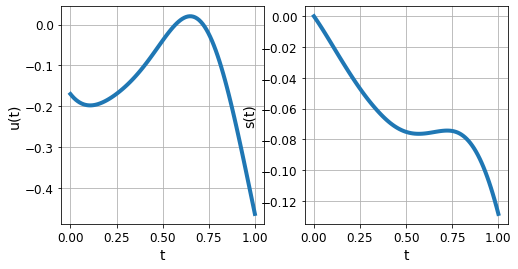

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
index = 25
ax[0].plot(np.linspace(0, 1, 100), X_test[index*100, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u(t)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(np.linspace(0, 1, 100), y_test[index*100:(index+1)*100], lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True)

#### Separate initial condition and collocation points

In [8]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling 
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

### 3. Physics-informed DeepONet

#### Define a custom layer for adding a bias

In [9]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

#### Define Physics-informed DeepONet

In [10]:
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.
    
    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the DeepONet model
    """
    
    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)
    
    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)   
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)
    
    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)
    
    # Add the bias
    output = BiasLayer()(dot_product)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)
    
    if verbose:
        model.summary()
        
    return model   

#### ODE loss

In [11]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"forcing": u, "time": t})
    
    # Calculate gradients
    ds_dt = tape.gradient(s, t)
    
    # ODE residual
    ODE_residual = ds_dt - u_t
    
    return ODE_residual

#### Gradient descent step

In [12]:
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

#### Define Loss Tracking class

In [13]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

#### Training

In [14]:
# Set up training configurations
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):
    
    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True)]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for X_init, X in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init, 
                                                                IC_weight, ODE_weight,
                                                                PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        ####### Validation
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")
        
        # Predict on one specific train samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"forcing": X_test[sample_id*100:(sample_id+1)*100, 1:-1], 
                                            "time": X_test[sample_id*100:(sample_id+1)*100, :1]}, batch_size=12800))
        
        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size) 

Epoch 1:
IC=1.9532e-02,               ODE=1.4509e-01,               total_loss=1.6462e-01
val_IC: 2.7148e-03, val_ODE: 3.0153e-02, lr: 1.00e-03
RMSE: 0.07514461800801565
Epoch 2:
IC=2.1721e-03,               ODE=2.6576e-02,               total_loss=2.8748e-02
val_IC: 1.4970e-03, val_ODE: 1.6988e-02, lr: 1.00e-03
RMSE: 0.05295505124265996
Epoch 3:
IC=1.4255e-03,               ODE=1.6997e-02,               total_loss=1.8422e-02
val_IC: 9.9056e-04, val_ODE: 1.2226e-02, lr: 1.00e-03
RMSE: 0.03948051411473997
Epoch 4:
IC=8.9386e-04,               ODE=1.3014e-02,               total_loss=1.3908e-02
val_IC: 5.9614e-04, val_ODE: 1.1456e-02, lr: 1.00e-03
RMSE: 0.038794397423852565
Epoch 5:
IC=6.3911e-04,               ODE=1.1064e-02,               total_loss=1.1703e-02
val_IC: 3.9831e-04, val_ODE: 9.0254e-03, lr: 1.00e-03
RMSE: 0.02800979480323516
Epoch 6:
IC=4.8221e-04,               ODE=9.5008e-03,               total_loss=9.9830e-03
val_IC: 2.8523e-04, val_ODE: 7.8051e-03, lr: 1.00e-03
RMSE:

IC=6.9315e-05,               ODE=9.0433e-04,               total_loss=9.7364e-04
val_IC: 1.7776e-04, val_ODE: 2.7064e-03, lr: 1.00e-03
RMSE: 0.02479747036262818
Epoch 50:
IC=7.3330e-05,               ODE=9.7976e-04,               total_loss=1.0531e-03
val_IC: 6.4860e-05, val_ODE: 4.6045e-04, lr: 1.00e-03
RMSE: 0.011632687120233217
Epoch 51:
IC=6.0286e-05,               ODE=5.8139e-04,               total_loss=6.4168e-04
val_IC: 8.2428e-05, val_ODE: 3.5953e-04, lr: 1.00e-03
RMSE: 0.013265592959264348
Epoch 52:
IC=8.8855e-05,               ODE=7.9140e-04,               total_loss=8.8026e-04
val_IC: 1.3636e-04, val_ODE: 1.5614e-03, lr: 1.00e-03
RMSE: 0.015070704382291465
Epoch 53:
IC=9.5122e-05,               ODE=7.8928e-04,               total_loss=8.8440e-04
val_IC: 2.6556e-05, val_ODE: 4.0269e-04, lr: 1.00e-03
RMSE: 0.009410133991001228
Epoch 54:
IC=7.0412e-05,               ODE=7.9502e-04,               total_loss=8.6544e-04
val_IC: 9.0667e-05, val_ODE: 4.8052e-04, lr: 1.00e-03
RMSE: 

IC=4.0730e-05,               ODE=5.9095e-04,               total_loss=6.3168e-04
val_IC: 4.4874e-05, val_ODE: 3.8499e-04, lr: 1.00e-03
RMSE: 0.010084121411171902
Epoch 98:
IC=3.3941e-05,               ODE=6.5351e-04,               total_loss=6.8745e-04
val_IC: 4.1491e-05, val_ODE: 4.0734e-04, lr: 1.00e-03
RMSE: 0.008349246922466264
Epoch 99:
IC=4.4293e-05,               ODE=6.4226e-04,               total_loss=6.8656e-04
val_IC: 8.4531e-05, val_ODE: 1.4451e-03, lr: 1.00e-03
RMSE: 0.020225873462094944
Epoch 100:
IC=1.8124e-05,               ODE=2.5899e-04,               total_loss=2.7711e-04
val_IC: 1.1105e-05, val_ODE: 1.7571e-04, lr: 5.00e-04
RMSE: 0.005425776421639788
Epoch 101:
IC=8.9257e-06,               ODE=1.8014e-04,               total_loss=1.8906e-04
val_IC: 7.7053e-06, val_ODE: 1.6189e-04, lr: 5.00e-04
RMSE: 0.004460573469624823
Epoch 102:
IC=9.5302e-06,               ODE=1.7433e-04,               total_loss=1.8386e-04
val_IC: 4.9657e-06, val_ODE: 1.4973e-04, lr: 5.00e-04
RM

IC=4.3390e-06,               ODE=1.3823e-04,               total_loss=1.4257e-04
val_IC: 4.3957e-06, val_ODE: 1.2176e-04, lr: 2.50e-04
RMSE: 0.003640110136396699
Epoch 146:
IC=4.4869e-06,               ODE=1.3608e-04,               total_loss=1.4057e-04
val_IC: 3.0319e-06, val_ODE: 1.4078e-04, lr: 2.50e-04
RMSE: 0.004432744556066196
Epoch 147:
IC=4.4471e-06,               ODE=1.5249e-04,               total_loss=1.5694e-04
val_IC: 4.4311e-06, val_ODE: 1.3823e-04, lr: 2.50e-04
RMSE: 0.004017484982568389
Epoch 148:
IC=6.8957e-06,               ODE=1.4974e-04,               total_loss=1.5664e-04
val_IC: 7.9498e-06, val_ODE: 1.1487e-04, lr: 2.50e-04
RMSE: 0.003555133683170713
Epoch 149:
IC=5.1978e-06,               ODE=1.4829e-04,               total_loss=1.5349e-04
val_IC: 8.4529e-06, val_ODE: 1.2520e-04, lr: 2.50e-04
RMSE: 0.004119193492086758
Epoch 150:
IC=9.0561e-06,               ODE=1.4997e-04,               total_loss=1.5903e-04
val_IC: 6.6143e-06, val_ODE: 1.3840e-04, lr: 2.50e-04


IC=1.4578e-06,               ODE=6.9491e-05,               total_loss=7.0949e-05
val_IC: 1.4077e-06, val_ODE: 7.0337e-05, lr: 6.25e-05
RMSE: 0.0024163883811537624
Epoch 194:
IC=1.6969e-06,               ODE=6.9073e-05,               total_loss=7.0770e-05
val_IC: 1.6799e-06, val_ODE: 6.9159e-05, lr: 6.25e-05
RMSE: 0.0026007956622814167
Epoch 195:
IC=1.5128e-06,               ODE=6.8167e-05,               total_loss=6.9680e-05
val_IC: 1.4749e-06, val_ODE: 7.1731e-05, lr: 6.25e-05
RMSE: 0.0025499277508774705
Epoch 196:
IC=1.7006e-06,               ODE=6.8092e-05,               total_loss=6.9793e-05
val_IC: 2.4631e-06, val_ODE: 7.0630e-05, lr: 6.25e-05
RMSE: 0.002595519691479672
Epoch 197:
IC=1.8135e-06,               ODE=6.7271e-05,               total_loss=6.9085e-05
val_IC: 1.3582e-06, val_ODE: 7.1467e-05, lr: 6.25e-05
RMSE: 0.0025196555793424356
Epoch 198:
IC=1.7338e-06,               ODE=6.6620e-05,               total_loss=6.8354e-05
val_IC: 1.9310e-06, val_ODE: 6.9811e-05, lr: 6.25e

IC=9.4427e-07,               ODE=3.5175e-05,               total_loss=3.6120e-05
val_IC: 8.2539e-07, val_ODE: 3.9775e-05, lr: 3.13e-05
RMSE: 0.002159422896497103
Epoch 242:
IC=1.0587e-06,               ODE=3.5653e-05,               total_loss=3.6712e-05
val_IC: 7.8083e-07, val_ODE: 3.8451e-05, lr: 3.13e-05
RMSE: 0.0019913034252879635
Epoch 243:
IC=1.0892e-06,               ODE=3.4816e-05,               total_loss=3.5905e-05
val_IC: 1.1112e-06, val_ODE: 3.9916e-05, lr: 3.13e-05
RMSE: 0.0019055568817713006
Epoch 244:
IC=1.0575e-06,               ODE=3.4795e-05,               total_loss=3.5853e-05
val_IC: 1.2403e-06, val_ODE: 3.9512e-05, lr: 3.13e-05
RMSE: 0.0021433891931603244
Epoch 245:
IC=9.9672e-07,               ODE=3.3633e-05,               total_loss=3.4630e-05
val_IC: 1.1692e-06, val_ODE: 3.7783e-05, lr: 3.13e-05
RMSE: 0.002218618947562213
Epoch 246:
IC=9.2580e-07,               ODE=3.3713e-05,               total_loss=3.4639e-05
val_IC: 8.0195e-07, val_ODE: 3.6810e-05, lr: 3.13e-

IC=7.4398e-07,               ODE=2.4605e-05,               total_loss=2.5349e-05
val_IC: 7.9241e-07, val_ODE: 2.7015e-05, lr: 1.56e-05
RMSE: 0.0019172026871540025
Epoch 290:
IC=7.4353e-07,               ODE=2.4565e-05,               total_loss=2.5308e-05
val_IC: 9.4668e-07, val_ODE: 2.7129e-05, lr: 1.56e-05
RMSE: 0.0017884974110834255
Epoch 291:
IC=7.0091e-07,               ODE=2.4312e-05,               total_loss=2.5013e-05
val_IC: 5.4080e-07, val_ODE: 2.6794e-05, lr: 1.56e-05
RMSE: 0.0018107710148946678
Epoch 292:
IC=6.1400e-07,               ODE=2.3640e-05,               total_loss=2.4254e-05
val_IC: 6.8559e-07, val_ODE: 2.6391e-05, lr: 7.81e-06
RMSE: 0.0018109082981570175
Epoch 293:
IC=6.5220e-07,               ODE=2.3605e-05,               total_loss=2.4257e-05
val_IC: 4.6783e-07, val_ODE: 2.6286e-05, lr: 7.81e-06
RMSE: 0.0017338170455141778
Epoch 294:
IC=6.2678e-07,               ODE=2.3741e-05,               total_loss=2.4368e-05
val_IC: 5.4881e-07, val_ODE: 2.6654e-05, lr: 7.81

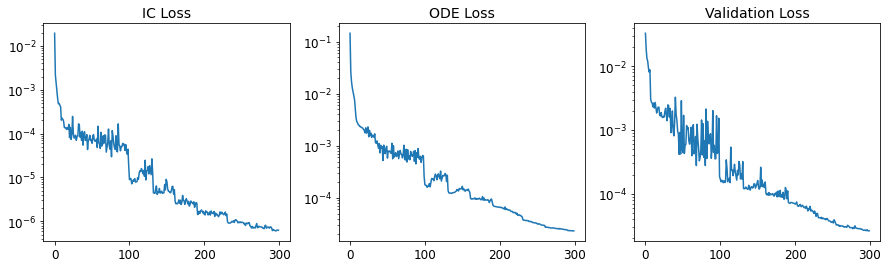

In [15]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Validation Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)
    
plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

#### Inspect accuracy on test set

In [16]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('NN_model.h5')

In [17]:
# Make prediction
pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False):.4e}")

RMSE: 1.7329e-03


#### Convergence display

<IPython.core.display.Javascript object>


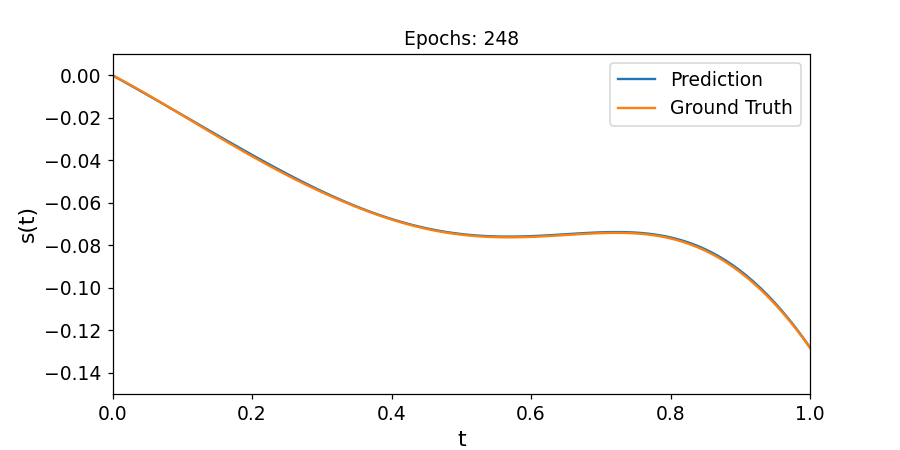

In [25]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Define the initialization function
def init():
    # Set up the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {0}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax,

# Define the update function
def update(epoch):
    # Clear the previous frame
    ax.cla()
    
    # Plot the loss convergence
    pred, = ax.plot(np.linspace(0, 1, 100), pred_profiles[epoch].flatten(), label="Prediction")
    truth, = ax.plot(np.linspace(0, 1, 100), y_test[25*100:(25+1)*100, :], label="Ground Truth")
    ax.legend(prop={'size': 12})  
    
    # Set the axes limits (if necessary)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {epoch}")
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    return line, 
    

# Create the animation
n_epochs = len(loss_tracker.loss_history['IC_loss'])  # Replace with the total number of epochs
frames = range(0, n_epochs, 2)
animation = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)

# Display the animation
plt.show()

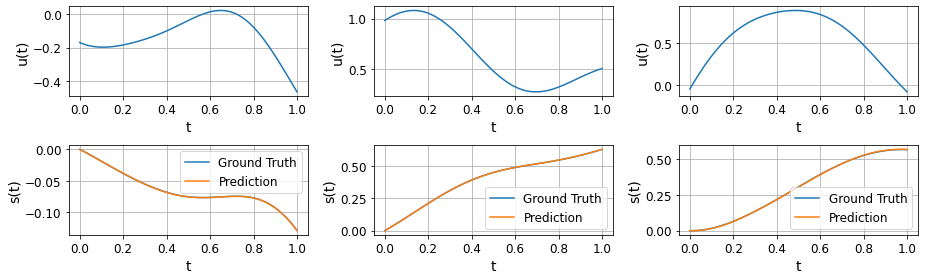

In [28]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    
    
    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig('testing.png', bbox_inches='tight', transparent=True)

#### Out-of-distribution prediction

In [38]:
# Create test dataset
N_test = 100
length_scale_test = 0.2
X, y = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 603.99it/s]


In [39]:
# Make prediction
pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y.flatten(), pred.flatten(), squared=False):.4e}")

RMSE: 4.8313e-02


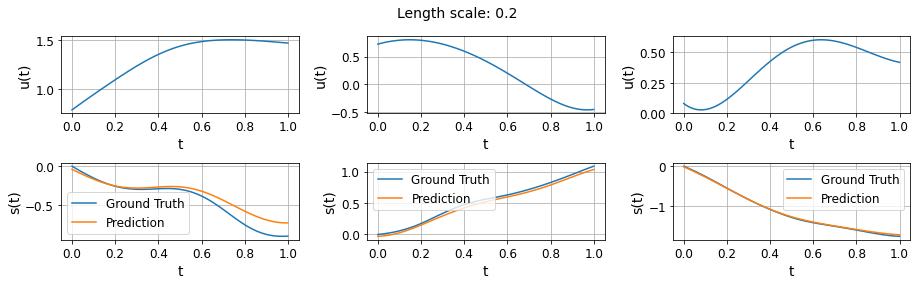

In [40]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    
    
    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

fig.suptitle(f'Length scale: {length_scale_test}', fontsize=14)
plt.tight_layout()
plt.savefig('testing_OOD.png', bbox_inches='tight', transparent=True)

#### Barplot for generalization capability

In [41]:
length_scale_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
RMSE = []
for length_scale in length_scale_list:
    # Create test dataset
    N_test = 100
    X, y = generate_dataset(N_test, length_scale, ODE_solve=True)
    
    # Make prediction
    pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

    # Overall accuarcy
    RMSE.append(mean_squared_error(y.flatten(), pred.flatten(), squared=False))

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 777.25it/s]


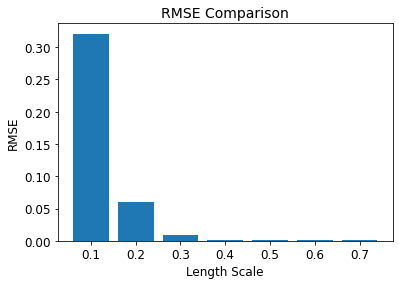

In [48]:
# Generate bar plot
plt.bar(range(len(RMSE)), RMSE)

# Set x-axis tick labels
plt.xticks(range(len(RMSE)), length_scale_list)

# Set x and y axis labels
plt.xlabel('Length Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Set a title for the plot
plt.title('RMSE Comparison', fontsize=14)

# Save the plot
plt.savefig('testing_OOD_bar.png', bbox_inches='tight', transparent=True)